1. congen2, 6+6 laers, old ddG tophalf dataset, property ddG
2. congen3, 6+6 laers, old ddG tophalf dataset, property solubility, 按ddG tophalf data的数据集来训练
3. congen4, 6+6 laers, old ddG tophalf dataset, property ddG_solubility co-optimize
4. congen5, 6+6 laers, old ddG tophalf dataset, + cycle perturb consistency
5. congen7, 24+24 layers, new ddG tophalf dataset, property ddG
6. congen8, 6+6 layers, new ddG tophalf dataset, property ddG

In [4]:
%ls

6lzg_Repair.pdb                foldx_20231231*  prepare foldx input.ipynb
analyze_new_data.ipynb         foldx_input/     rotabase.txt
analyz_foldx_eval_ibex.ipynb   foldx_output/    run_foldx_eval_ibex.ipynb
analyz_foldx_train_ibex.ipynb  gen_data/        run_foldx_top_ibex.ipynb
avg_rank_ddG_df.csv            molecules/       run_foldx_train_ibex.ipynb
download_model/                new_train_data/  temp/
figures/                       old_train_data/


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import concurrent.futures
import multiprocessing

## setting

In [6]:
foldx_dir = '/home/hew/python/genhance/foldx/'
foldx_exe_path = foldx_dir + 'foldx_20231231'
numberOfRuns = 5
time_per_mut = 3
time = '{}:00'
foldx_command = '-c BuildModel --numberOfRuns {} --pdb=6lzg_Repair.pdb --mutant-file={} --output-dir={}'
submit_script = 'sbatch --job-name={} --output={}%j.out --error={}%j.err --time={} {}'
eval_input_dir = foldx_dir + 'foldx_input/'
eval_output_dir = foldx_dir + 'foldx_output/'

In [9]:
input_list = list(os.walk(eval_input_dir))[0][1][1:]
input_list

['congen2_260000_[-1.5]',
 'congen2_260000_[-2.0]',
 'congen5_260000_[-1.0]',
 'congen2_250000_[-1.0]',
 'congen4_250000_[-1.0]',
 '.ipynb_checkpoints',
 'congen8_new_ddG_260000_[-2.2]_[5.0]',
 'congen8_new_ddG_260000_[-2.2]_[6.0]',
 'congen8_new_ddG_260000_[-2.2]_[2.0]',
 'congen8_new_ddG_260000_[-12.0]_[2.0]',
 'congen8_new_ddG_260000_[-3.3]_[2.0]',
 'congen8_new_ddG_260000_[-4.4]_[2.0]',
 'congen8_new_ddG_260000_[-8.0]_[2.0]',
 'congen8_new_ddG_260000_[-2.2]_[4.0]',
 'congen7_new_ddG_260000_[-1.1]_[2.0]',
 'congen8_new_ddG_260000_[-1.1]_[2.0]',
 'congen8_new_ddG_260000_[-2.2]_[3.0]',
 'congen8_new_ddG_260000_[-16.0]_[2.0]',
 'congen8_new_ddG_260000_[-20.0]_[2.0]',
 'congen8_new_ddG_260000_[-40.0]_[2.0]',
 'congen8_new_ddG_260000_[-30.0]_[2.0]',
 'congen8_new_ddG_260000_[-40.0]_[1.0]',
 'congen10_new_ddG_solubility_6_layer_gens_step_final_[-40.0]_[1.0]_[1.0]',
 'congen10_new_ddG_solubility_6_layer_gens_step_final_[-30.0]_[1.0]_[1.0]',
 'congen9_new_solubility_6_layer_gens_step_final_

In [10]:
input_index = -1
output_dir_suffix = ''
# output_dir_suffix = '_Emin'
# output_dir_suffix = '_ddG_top1000'
property_name = 'solubility'
# property_name = 'ddG'
# topk = 100
# property_name = 'ddG_solubility_avg'
topk = 1000

input_dir = f'{eval_input_dir}/{input_list[input_index]}/'
output_dir = f'{eval_output_dir}/{input_list[input_index]}{output_dir_suffix}/'
mutant_file = 'individual_list.txt'
seq_file = 'sequence.txt'
script_file = 'script.sh'
script_head = '#!/bin/bash\n\n'
    
topk_tsv = input_dir + f'{property_name}_top{topk}.tsv'
# topk_tsv = input_dir + f'{property_name}_Emin_df.tsv'
topk_tsv, output_dir

('/home/hew/python/genhance/foldx/foldx_input//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/solubility_top1000.tsv',
 '/home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/')

In [11]:
os.makedirs(output_dir, exist_ok=True)

In [12]:
WT_seq = 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ'
WT_seq

'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ'

## preprocessing

In [13]:
topk_df = pd.read_csv(topk_tsv, sep='\t')
topk_df

,MT_seq,ddG_latent_pred,solubility_latent_pred,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen
0,STIEEQAKTFLDKFNHEAEDLFYQSSLASNPMNTNITEENVQNMNN...,NaN,11.767674,STIEEQAKTFLDKFNHEAEDLFYQSSLASRNTNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
1,STIEEQAKTFEDKFNHEAEDLFYQSSLASRNNNTNITEENVQNMNN...,NaN,11.687727,STIEEQAKTFLDKFNHEAEDLFYQSSLASRNTNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
2,STIEEQAKTFLDKFNHEAEDPFYQSSLASINQNTNITEENVQNMNN...,NaN,11.654788,STIEEQAKTFLDKFNHEAEDLFYQSSLASINQNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
3,STIEEQAKTFLDKPNHEAEDTFTQSSLASWNYNTNITEENVQNMNN...,NaN,11.653510,STIEEQAKTFLDKPNHEAEDTFSQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
4,STIEEQAKTFLDKFNHEAEDLEYQSSLASANPNTNITEENVQNMNN...,NaN,11.641774,STIEEQAKTFLDKFNHEAEDLEYQSSLASPNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
...,...,...,...,...,...,...,...,...,...,...
995,STIEEQGKTFLDKMNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,NaN,11.012128,STIEEQGKTFLDKLNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
996,STIEEQVKTFLDKFNHEAEDLIYQSSLASPNENTNITEENVPNMNN...,NaN,11.012104,STIEEQVKTFLDKFNHEAEDLIYQSSLASPNENTNITEENVPNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
997,STIEEQAKTFLDKNNHEAEDLFVQSSLASWNENTNITEENVQNMNN...,NaN,11.011950,STIEEQAKTFLDKNNHEAEDLFVQSSLASWNENTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
998,STIEEQAKTFLDKFNHEAEDLTYQISLASENYNTNITEENVQNMNN...,NaN,11.011925,STIEEQAKTFLDKFNHEAEDLTYQISLASENYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False


In [14]:
set(topk_df.repeated_gen), set(topk_df.in_train_data_gen)

({False}, {False})

In [15]:
def get_mutation(WT_seq, MT_seq):
    assert len(WT_seq) == len(MT_seq)
    mut_list = ['{}A{}{}'.format(WT_seq[i], i + 1 + 18, MT_seq[i]) for i in range(len(WT_seq)) if WT_seq[i] != MT_seq[i]]
    return mut_list


def format_mutation_string(mut_list):
    return ','.join(mut_list) + ';'


def format_batch_mutation_string(mut_lists):
    return '\n'.join([format_mutation_string(mut_list) for mut_list in mut_lists])


def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print("mkdir: ", path)


def write_mutant_file(mutant_file_content, mutant_file, suffix=''):
    mutant_file = mutant_file.format(suffix)
    with open(mutant_file, 'w') as f:
        f.write(mutant_file_content)
    return mutant_file


def write_seqs_file(seqs, file, suffix=''):
    file = file.format(suffix)
    with open(file, 'w') as f:
        f.write(seqs)
        
def write_run_script(command, file, suffix=''):
    file = file.format(suffix)
    with open(file, 'w') as f:
        f.write(command)

In [16]:
seqs_for_foldx_list = topk_df.MT_seq.to_list()
seqs_for_foldx_list[:10]

['STIEEQAKTFLDKFNHEAEDLFYQSSLASNPMNTNITEENVQNMNNAGDKPSAELKEQSTLAQMYPLQEIQNLTVKRQLQALQ',
 'STIEEQAKTFEDKFNHEAEDLFYQSSLASRNNNTNITEENVQNMNNAGDKESAGSKEQSTEAQMYPLQEIQNLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDPFYQSSLASINQNTNITEENVQNMNNAGDKWKAFLKEQSTLAQMDPLQEIQNLTVKAQLEANQ',
 'STIEEQAKTFLDKPNHEAEDTFTQSSLASWNYNTNITEENVQNMNNAGDKWSATLKEQSTLAQMEPTQEIQNLTVKLQLQPLQ',
 'STIEEQAKTFLDKFNHEAEDLEYQSSLASANPNTNITEENVQNMNNAGDKWSAPLKEVSTLAQMYPEQEIQNLTVKNQLQAQQ',
 'STIEEQAKTFLDKFNHEAEDLFMQSSLASWNYNTNITEENVQNMNNAGDKESRVLKEQSTLAQMDPLQEIQNLTVKLQLQALQ',
 'STIEEQARTFLDKFNHEAEDPFNQSSLASDNYNTNITEENVQNMNNAGDKWSAGLKEQSTLAQMEPLQEIQNLTVKLQLQALD',
 'STIEEQAKTFLDKFNHEAEDLEYQRSLASWNYNTNITEENVQNMNNAGDKPSAMLKEQSTLAQMGPLQEIQNITVKEQLQALD',
 'STIEEQAKTVLDKFNHEAEDLFYQSSLASWNVNTNITEENVQNMDNSGDKWSAPLKEQSTLAQMEPLQEIQNATVKKQLQALQ',
 'STREEQAKTFLDKFNHEAEDLFYQSSLASDNYNTNITEENVQNMNNAGDKQSAVNKEMSTLAQMNPLQEIQNLTVKLQLQALQ']

(array([  1.,   0.,   0.,   0.,  25.,   0.,   0.,   0., 133.,   0.,   0.,
          0., 258.,   0.,   0.,   0., 310.,   0.,   0., 273.]),
 array([3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25, 5.5 ,
        5.75, 6.  , 6.25, 6.5 , 6.75, 7.  , 7.25, 7.5 , 7.75, 8.  ]),
 <BarContainer object of 20 artists>)

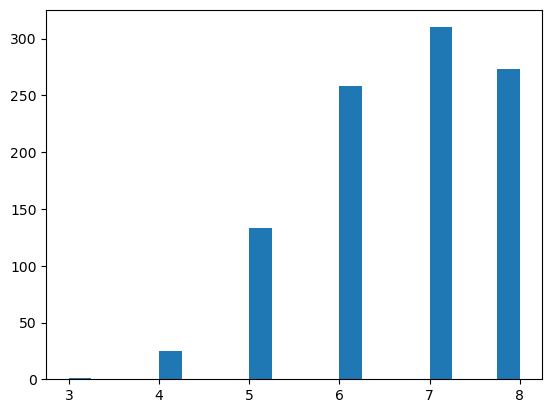

In [17]:
mut_lists = []
for MT_seq in seqs_for_foldx_list:
    mut_list = get_mutation(WT_seq, MT_seq)
    mut_lists.append(mut_list)

mut_num = [len(mut_lists[i]) for i in range(len(mut_lists))]
plt.hist(mut_num, bins=20)

In [18]:
mut_lists[:10], len(mut_lists)

([['WA48N', 'NA49P', 'YA50M', 'WA69P', 'FA72E', 'LA95R'],
  ['LA29E', 'WA48R', 'YA50N', 'WA69E', 'FA72G', 'LA73S', 'LA79E'],
  ['LA39P', 'WA48I', 'YA50Q', 'SA70K', 'YA83D', 'LA95A', 'QA98E', 'LA100N'],
  ['FA32P', 'LA39T', 'YA41T', 'FA72T', 'YA83E', 'LA85T', 'AA99P'],
  ['FA40E', 'WA48A', 'YA50P', 'FA72P', 'QA76V', 'LA85E', 'LA95N', 'LA100Q'],
  ['YA41M', 'WA69E', 'AA71R', 'FA72V', 'YA83D'],
  ['KA26R', 'LA39P', 'YA41N', 'WA48D', 'FA72G', 'YA83E', 'QA101D'],
  ['FA40E', 'SA43R', 'WA69P', 'FA72M', 'YA83G', 'LA91I', 'LA95E', 'QA101D'],
  ['FA28V', 'YA50V', 'NA63D', 'AA65S', 'FA72P', 'YA83E', 'LA91A', 'LA95K'],
  ['IA21R', 'WA48D', 'WA69Q', 'FA72V', 'LA73N', 'QA76M', 'YA83N']],
 1000)

In [19]:
one_string = format_mutation_string(mut_lists[0])
one_string

'WA48N,NA49P,YA50M,WA69P,FA72E,LA95R;'

## generate parrallel commands

In [20]:
commands = []
scripts = []
for i, seq_i in enumerate(seqs_for_foldx_list):
    job_dir_i = output_dir + f'job_{i}/'
    mkdir(job_dir_i)
    
    # write sequence.txt
    write_seqs_file(seq_i, job_dir_i + seq_file)
    
    # write individual_list.txt
    mut_strings_i = format_mutation_string(mut_lists[i])
    mutant_file_i = write_mutant_file(mut_strings_i, job_dir_i + mutant_file)
    
    # write script.sh
    command_i = foldx_exe_path + ' ' + foldx_command.format(numberOfRuns, mutant_file_i, job_dir_i)
    write_run_script(script_head + command_i, job_dir_i + script_file)
    
    # format run script
    time_i = len(mut_lists[i])*time_per_mut if len(mut_lists[i]) <= 5 else len(mut_lists[i])*(time_per_mut+1)
    time_i = time.format(time_i)
    script_i = submit_script.format(f'top_{i+1}', job_dir_i, job_dir_i, time_i, job_dir_i +  script_file)
    
    commands.append(command_i)
    scripts.append(script_i)

mkdir:  /home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_0/
mkdir:  /home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_1/
mkdir:  /home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_2/
mkdir:  /home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_3/
mkdir:  /home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_4/
mkdir:  /home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_5/
mkdir:  /home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_6/
mkdir:  /home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_7/
mkdir:  /home/hew/python/genhance/foldx/

In [21]:
commands[:5]

['/home/hew/python/genhance/foldx/foldx_20231231 -c BuildModel --numberOfRuns 5 --pdb=6lzg_Repair.pdb --mutant-file=/home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_0/individual_list.txt --output-dir=/home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_0/',
 '/home/hew/python/genhance/foldx/foldx_20231231 -c BuildModel --numberOfRuns 5 --pdb=6lzg_Repair.pdb --mutant-file=/home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_1/individual_list.txt --output-dir=/home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_1/',
 '/home/hew/python/genhance/foldx/foldx_20231231 -c BuildModel --numberOfRuns 5 --pdb=6lzg_Repair.pdb --mutant-file=/home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_2/individual_list.txt --out

In [22]:
scripts[:5]

['sbatch --job-name=top_1 --output=/home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_0/%j.out --error=/home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_0/%j.err --time=24:00 /home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_0/script.sh',
 'sbatch --job-name=top_2 --output=/home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_1/%j.out --error=/home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_1/%j.err --time=28:00 /home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_1/script.sh',
 'sbatch --job-name=top_3 --output=/home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/job_2/%j.out --error=/home/hew

In [23]:
# scripts = scripts[5:]
run_file = output_dir + 'run.sh'
head = '#!/bin/bash\n\n'
write_run_script(head + '\n'.join(scripts), run_file)
run_file, len(scripts)

('/home/hew/python/genhance/foldx/foldx_output//congen9_new_solubility_6_layer_gens_step_final_[1.0]_[1.0]/run.sh',
 1000)

## run foldx

In [24]:
# os.system(f'sh {run_file}')

In [25]:
def get_squeue_number(username = "hew"):
    command = f"squeue -u {username}"
    output = subprocess.check_output(command, shell=True, text=True)
    # print('top_142' in output)
    # print('top_143' in output)
    # print('top_144' in output)
    lines = output.strip().split('\n')
    return len(lines) - 1

squeue_number = get_squeue_number()
squeue_number

0

In [26]:
os.system('squeue -u hew')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


0

In [27]:
current_i = 0
is_return = True
max_job_num = 1000

In [28]:
while current_i < len(scripts):
    if get_squeue_number() < max_job_num:
        os.system(f'{scripts[current_i]}') 
        current_i += 1
        if current_i%10==0:
            print('current_script_i:', current_i)
    else:
        if is_return:
            break
        else:
            time.sleep(2)
            print('[waiting to submit] current_script_i:', current_i)

current_i        

Submitted batch job 25414057
Submitted batch job 25414058
Submitted batch job 25414059
Submitted batch job 25414060
Submitted batch job 25414061
Submitted batch job 25414062
Submitted batch job 25414063
Submitted batch job 25414064
Submitted batch job 25414065
Submitted batch job 25414066
current_script_i: 10
Submitted batch job 25414067
Submitted batch job 25414068
Submitted batch job 25414069
Submitted batch job 25414070
Submitted batch job 25414071
Submitted batch job 25414072
Submitted batch job 25414073
Submitted batch job 25414074
Submitted batch job 25414075
Submitted batch job 25414076
current_script_i: 20
Submitted batch job 25414077
Submitted batch job 25414078
Submitted batch job 25414079
Submitted batch job 25414080
Submitted batch job 25414081
Submitted batch job 25414082
Submitted batch job 25414083
Submitted batch job 25414084
Submitted batch job 25414085
Submitted batch job 25414086
current_script_i: 30
Submitted batch job 25414087
Submitted batch job 25414088
Submitted

1000

In [29]:
current_i

1000

In [33]:
def get_squeue_number(username = "hew"):
    command = 'squeue -u hew --format="%.8i %.9P %38j %10u %.8T %.12M %30N"'
    output = subprocess.check_output(command, shell=True, text=True)
    lines = output.strip().split('\n')
    num_queue = len(lines) - 1
    num_unfinished = sum([1 for line in lines if 'index_230' in line])
    num_pending = sum([1 for line in lines if 'PENDING' in line])
    num_running = sum([1 for line in lines if 'RUNNING' in line])
    print('num_queue:', num_queue)
    print('num_unfinished:', num_unfinished)
    print('num_pending:', num_pending)
    print('num_running:', num_running)
    print('num_others:', num_queue - num_pending - num_running)
    return num_queue

squeue_number = get_squeue_number()
squeue_number

num_queue: 0
num_unfinished: 0
num_pending: 0
num_running: 0
num_others: 0


0

In [31]:
os.system('squeue -u hew')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          25415058     batch top_1000      hew PD       0:00      1 (None)
          25415057     batch  top_999      hew PD       0:00      1 (None)
          25415056     batch  top_998      hew PD       0:00      1 (None)
          25415055     batch  top_997      hew PD       0:00      1 (None)
          25415054     batch  top_996      hew PD       0:00      1 (None)
          25415053     batch  top_995      hew PD       0:00      1 (None)
          25415052     batch  top_994      hew PD       0:00      1 (None)
          25415051     batch  top_993      hew PD       0:00      1 (None)
          25415050     batch  top_992      hew PD       0:00      1 (None)
          25415049     batch  top_991      hew PD       0:00      1 (None)
          25415048     batch  top_990      hew PD       0:00      1 (None)
          25415047     batch  top_989      hew PD       0:00      1 (None)
          25415

0

In [32]:
os.system('squeue -u hew -t RUNNING')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          25414967     batch  top_909      hew  R       0:15      1 cn605-17-l
          25414968     batch  top_910      hew  R       0:15      1 cn512-14-r
          25414969     batch  top_911      hew  R       0:15      1 cn509-03-r
          25414970     batch  top_912      hew  R       0:15      1 cn513-18-l
          25414971     batch  top_913      hew  R       0:15      1 cn513-18-l
          25414972     batch  top_914      hew  R       0:15      1 cn513-18-l
          25414973     batch  top_915      hew  R       0:15      1 cn513-18-l
          25414974     batch  top_916      hew  R       0:15      1 cn513-18-l
          25414975     batch  top_917      hew  R       0:15      1 cn513-18-l
          25414976     batch  top_918      hew  R       0:15      1 cn513-18-l
          25414977     batch  top_919      hew  R       0:15      1 cn513-18-l
          25414978     batch  top_920      hew

0